In this notebook we plot and analyze the discovered amplifier lattices

In [1]:
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt

import autolattice.plothelpers as phelp
import autolattice.architecture as arch

import os
import glob
import autolattice.constraints as msc
import autolattice.architecture_optimizer as arch_opt

from IPython.display import display
import ipywidgets as widgets

from autolattice.definitions import LEFT_TO_RIGHT, RIGHT_TO_LEFT

def unify_dicts(*dicts):
    keys = dicts[0]
    unified_dict = {}
    for key in keys:
        to_unify = []
        for d in dicts:
            element = d[key]
            if len(element) != 0:
                to_unify.append(element.T)
        unified_dict[key] = np.hstack(to_unify).T

    return unified_dict

def get_solutions_for_graphs(list_of_graphs):
    return np.array([unified_dict['solutions'][np.where(np.all(unified_dict['graphs_tested'] == graph, -1))[0]][0] for graph in list_of_graphs])

I0000 00:00:1765294451.409153   26224 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
load_folder = 'results/amplifiers'

print('#loading the following code:')
with open(os.path.join(load_folder, "setup.py")) as f:
    code = f.read()
    print(code)
    exec(code)

optimizer.prepare_all_possible_combinations()
num_chains = len(optimizer.list_possible_graphs)

plot_functions = phelp.prepare_plot_functions_for_plotting(optimizer, 10)

#loading the following code:
save_folder = 'amplifiers/min_distance7'

target_scaling_rate = 1.2
constraints_scaling = [
    msc.Scaling_Rate_Constraint(target_scaling_rate),
    msc.Scaling_Rate_Constraint(0., gradient_order=1),
    msc.Scaling_Rate_Constraint(0., gradient_order=2),
    msc.Scaling_Rate_Constraint(0., gradient_order=3),
    # msc.Scaling_Rate_Constraint(0., gradient_order=4),
    # msc.Prefactor_Constraint(1.),
    msc.Prefactor_Constraint(0., gradient_order=1),
    # msc.Prefactor_Constraint(0., gradient_order=2),
    # msc.Prefactor_Constraint(0., gradient_order=3),
    # msc.Min_Distance_Eigvals(),
    msc.Min_Distance_Eigvals_range(jnp.linspace(-3., 3., 121), 0.05),
    msc.Stability_Constraint(10),
]

kwargs_bounds = {'bounds_extrinsic_loss': [0., np.inf]}

optimizer = arch_opt.Architecture_Optimizer(
    2,
    mode_types=[True, False, True],
    enforced_constraints=constraints_scaling,
    kappas_free_parameters=[False, True],
    port_intrinsic_losses=[False,

288it [00:00, 563940.03it/s]


sorted out 8 graphs, where the unit cells were decoupled


In [4]:
all_result_files = sorted(glob.glob(os.path.join(load_folder, '*.npz')))
num_files = len(all_result_files)
if num_files % 32 != 0:
    raise Warning('sumething seems odd with the number of result files (%i)'%num_files)
all_data = [dict(np.load(filename)) for filename in all_result_files]

unified_dict = unify_dicts(*all_data)
idxs_success = np.where(unified_dict['success'])
valid_graphs = unified_dict['graphs_tested'][idxs_success]
optimizer.valid_combinations = valid_graphs
optimizer.cleanup_valid_combinations()
irreducible_graphs = optimizer.valid_combinations

irreducible_graphs_solutions = get_solutions_for_graphs(irreducible_graphs)

print('found %i irreducible graphs'%len(irreducible_graphs))

65it [00:00, 8116.88it/s]

found 5 irreducible graphs


In [5]:
omegas = np.linspace(-4., 4., 201)

def make_isolator_plot(input_array, plot_functions):
    fig, axes = plt.subplots(ncols=3, figsize=(3*2.3, 2.))
    ax_rate = axes[0]
    ax_prefactor = axes[1]
    ax_gain = axes[2]

    scattering_chain = plot_functions['scattering_func'](omegas, input_array)
    prefactors, scaling_rate, info = plot_functions['scaling_func'](omegas, input_array)

    print(np.abs(scaling_rate[len(omegas)//2]))

    eigval_colors = ['C2', 'C0', 'C1', 'C3']
    for idx in range(4):
        ax_rate.plot(omegas, np.abs(info['eigvals'][:,idx]), color=eigval_colors[idx])
    # ax_rate.plot(omegas, np.abs(scaling_rate))
    ax_prefactor.plot(omegas, np.abs(prefactors[:,0,0]))
    
    ax_gain.plot(omegas, np.abs(scattering_chain[:,-2,0])**2, label='gain')
    ax_gain.semilogy(omegas, np.abs(scattering_chain[:,0,-2])**2, label='reverse gain')

    for ax in axes:
        ax.set_xlim(omegas[0], omegas[-1])
        ax.set_xticks([-4, -2, 0, 2, 4])
        ax.axhline(1., color='gray', ls='dashed', zorder=-100)
        ax.set_xlabel(r'$\omega/\kappa_\mathrm{in}$')
    
    ax_rate.set_ylim(0, 2)
    ax_prefactor.set_ylim(0, None)# 1.2)
    ax_gain.set_ylim(10**-6, 10**4)# 1.2)

    # ax_gain.set_yticks([10**-2, 1, 100])

    ax_rate.set_ylabel('abs(eigenvalues)')
    ax_prefactor.set_ylabel('prefactor')
    ax_gain.set_ylabel('gain')

    fig.tight_layout(h_pad=0.)

    return fig, axes

def plot_result(intput_array, plot_functions):
    pass

In [6]:
num_unit_cells = 5

os.system('rm %s'%os.path.join(load_folder, '*.pdf'))

rows = []

list_kwargs_noise = None #[{}, {'opening_angles': [50,55,60]}]
noise_orientations= [np.pi, 0] #[np.pi, -0.8]
# {'width_factor': 0.85, 'distance': 0.12, 'opening_angles': [65,70,75], 'base_width_radius_factor': 2.7, 'width_factor': 0.85, 'linewidth': 2}

for idx in range(len(irreducible_graphs)):

    if idx == 0 or idx == 1:
        noise_orientations=[np.pi, -0.7]
        # orientation_detunings = [np.pi-0.7,0.7]
        orientation_detunings = [np.pi-0.7,0.]
    else:
        noise_orientations= [np.pi, 0]


    fig_chain, ax, G = arch.draw_chain_cell(
        irreducible_graphs[idx],
        num_following_unit_cells=num_unit_cells-1,
        positions_unit_cell='straight',
        distance_next_unit_cell=1,
        node_colors_unit_cell=['orange', '#D5D5D5'],
        noise_orientations=noise_orientations,
        orientation_detunings=[0, 0.6],
        kwargs_draw={'detuning_radius_factor': 0.6},
        mode_types=optimizer.mode_types,
        modes_without_noise=[0,-2],
        scale=0.7,
        list_of_kwargs_noise=list_kwargs_noise
    )

    fig_scaling, _ = make_isolator_plot(irreducible_graphs_solutions[idx], plot_functions)

    filename_chain = str(idx).zfill(3) + '-chain.pdf'
    filename_scaling = str(idx).zfill(3) + '-scaling.pdf'
    fig_chain.savefig(os.path.join(load_folder, filename_chain))
    fig_scaling.savefig(os.path.join(load_folder, filename_scaling))
    
    output1 = widgets.Output()
    output2 = widgets.Output()
    label = widgets.HTML(f"<div style='font-size:40px; font-weight:bold;'>{idx}</div>", layout=widgets.Layout(width='70px'))

    with output1:
        display(fig_chain)
    with output2:
        display(fig_scaling)

    hbox = widgets.HBox([label, output1, output2], layout=widgets.Layout(align_items="center"))

    rows.append(hbox)

    plt.close(fig_scaling)
    plt.close(fig_chain)

vbox = widgets.VBox(rows)
display(vbox)

1.1996494171893932


1.1994406636261963


1.1999910294891099


1.200910898435443


1.1996629852818075


Analyze lattice 3 in more details

In [9]:
input_array = irreducible_graphs_solutions[-2]

omegas = np.linspace(-3., 3., 301)
scattering_chain = np.array(plot_functions['scattering_func'](omegas, input_array))

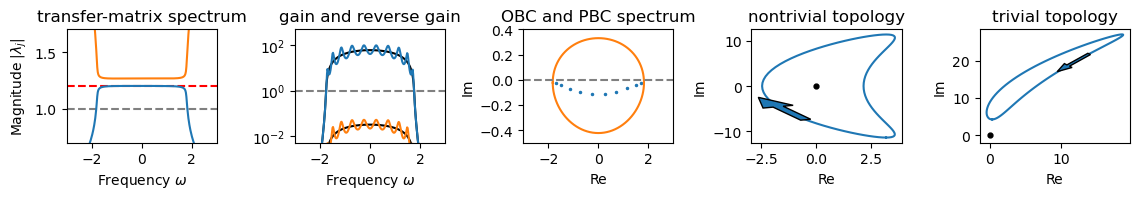

In [21]:
def calc_continuous_PBC(mus, ks=jnp.linspace(-np.pi, np.pi, 101)):
    mu_m1, mu_0, mu_p1 = mus
    H_k = jnp.exp(-1.j*ks)[:,None,None] * mu_m1[None] + mu_0[None] + jnp.exp(1.j*ks)[:,None,None] * mu_p1[None]
    eigvals = jnp.linalg.eigvals(H_k)
    #sort eigvals according to their real part
    eigvals_order = jnp.argsort(jnp.real(eigvals), 1)
    return ks, jnp.take_along_axis(eigvals, eigvals_order, 1)

fig, axes = plt.subplots(ncols=5, figsize=(2.3*5,2.1))

ax_EVs = axes[0]
ax_gain = axes[1]
ax_OBC_PBC = axes[2]
ax_det_left = axes[3]
ax_det_right = axes[4]

chain_length = plot_functions['chain_length']
idx_left = 0
idx_right = 2 * (chain_length-1)

prefactors, scaling_rate, info = plot_functions['scaling_func'](omegas, input_array)

eigval_colors = ['C2', 'C0', 'C1', 'C3']
for idx in range(4):
    ax_EVs.plot(omegas, np.abs(info['eigvals'][:,idx]), color=eigval_colors[idx])

prefactor_right, scaling_rate_right, _ = plot_functions['scaling_func'](omegas, input_array)
prefactor_left, scaling_rate_left, _ = plot_functions['scaling_func_reverse'](omegas, input_array)
scaling_to_right = np.abs((prefactor_right[:,0,0] * scaling_rate_right**chain_length))**2
scaling_to_left = np.abs((prefactor_left[:,0,0] * scaling_rate_left**chain_length))**2

ax_gain.plot(omegas, scaling_to_right, color='black') #,
ax_gain.plot(omegas, scaling_to_left, color='black')
ax_gain.plot(omegas, np.abs(scattering_chain[:,idx_right,idx_left])**2, color='C0')
ax_gain.plot(omegas, np.abs(scattering_chain[:,idx_left,idx_right])**2, color='C1')

eigvals_OBC = jnp.linalg.eigvals(plot_functions['dynamical_matrix_OBC'](input_array))
eigvals_PBC = jnp.linalg.eigvals(plot_functions['dynamical_matrix_PBC'](input_array))
ks, eigvals_PBC_continuous = calc_continuous_PBC(optimizer.give_mus(input_array))

ax_OBC_PBC.plot(np.imag(eigvals_OBC), np.real(eigvals_OBC), label='OBC', marker='.', ls='None', markersize=3)
# ax_OBC_PBC.plot(np.imag(eigvals_PBC), np.real(eigvals_PBC), label='PBC', marker='.', ls='None')
for band_idx in range(2):
    ax_OBC_PBC.plot(np.imag(eigvals_PBC_continuous[:,band_idx]), np.real(eigvals_PBC_continuous[:,band_idx]), color='C1', marker='None',)
ax_OBC_PBC.axhline(0., color='gray', ls='dashed')

# ax_OBC_PBC.set_xticks([-4.,-2.,0,2,4])
ax_OBC_PBC.set_ylim(-0.5, 0.4)
ax_OBC_PBC.set_xlim(-3., 3.)


omega_center = 0.
omega_right = 2.5

k_arrow = 4.
delta_k = 0.3
_, [det_H_k_arrow] = phelp.calc_det_H_k(optimizer.give_mus(input_array), omega=omega_center, ks=jnp.array([k_arrow]))
_, [det_H_delta_k] = phelp.calc_det_H_k(optimizer.give_mus(input_array), omega=omega_center, ks=jnp.array([k_arrow+delta_k]))
ax_det_left.arrow(np.real(det_H_k_arrow), np.imag(det_H_k_arrow), np.real(det_H_delta_k-det_H_k_arrow), np.imag(det_H_delta_k-det_H_k_arrow), zorder=100, width=0.5)

ks, det_H_k = phelp.calc_det_H_k(optimizer.give_mus(input_array), omega=omega_center)
# ax_det_left.plot(np.imag(det_H_k), np.real(det_H_k), color='#EE220C')
ax_det_left.plot(np.real(det_H_k), np.imag(det_H_k), color='C0')


k_arrow = 1.
delta_k = 0.3
_, [det_H_k_arrow] = phelp.calc_det_H_k(optimizer.give_mus(input_array), omega=omega_right, ks=jnp.array([k_arrow]))
_, [det_H_delta_k] = phelp.calc_det_H_k(optimizer.give_mus(input_array), omega=omega_right, ks=jnp.array([k_arrow+delta_k]))
ax_det_right.arrow(np.real(det_H_k_arrow), np.imag(det_H_k_arrow), np.real(det_H_delta_k-det_H_k_arrow), np.imag(det_H_delta_k-det_H_k_arrow), zorder=100, width=0.5)

ks, det_H_k = phelp.calc_det_H_k(optimizer.give_mus(input_array), omega=omega_right)
# ax_det_right.plot(np.imag(det_H_k), np.real(det_H_k), color='#1DB100')
ax_det_right.plot(np.real(det_H_k), np.imag(det_H_k), color='C0')

for ax in [ax_det_right, ax_det_left]:
    ax.plot([0], [0], color='black', ls='None', marker='o', markersize=3.5)

# ax_OBC_PBC.set_ylim(-2.4, -1.95)
# ax_OBC_PBC.axhline(-2.07)

# ax_forward.axhline(1., color='gray', ls='dashed', zorder=-100)
for ax in [ax_gain, ax_EVs]:
    ax.axhline(1., color='gray', ls='dashed', zorder=-100)
    ax.set_xlim(omegas[0], omegas[-1])

# for ax in axes:
    # ax.set_xticks([-4.,-3,-2.,0,2,3,4])
    # ax.set_xticklabels([-4, '', -2, 0, 2, '', 4])
    # ax.axvline(-3., color='#EE220C', zorder=-100, ls='dashed')
    # ax.axvline(3., color='#1DB100', zorder=-100, ls='dashed')

ax_gain.set_yscale('log')
# ax_gain.set_ylim([10**-2, 3*10**1])
ax_EVs.axhline(target_scaling_rate, color='red', ls='dashed', zorder=-100)
# ax_gain.set_ylim([10**-4, 10**3])
ax_gain.set_ylim([5*10**-3, 5*10**2])
ax_gain.set_yticks([10**-2, 1, 10**2])
ax_EVs.set_ylim(target_scaling_rate-0.5, target_scaling_rate+0.5)
ax_EVs.set_yticks([1,1.5])
ax_OBC_PBC.set_yticks([-0.4,-0.2,0.,0.2,0.4])
ax_det_right.set_ylim([-2,None])
# ax_det_right.set_yticks([0,10,20,30])
# ax_det_right.set_xticks([0,5,10,15,20])
# ax_EVs.set_yticks([0.5, 1., 1.5])

# ax_backward.legend(loc='center', bbox_to_anchor=(0.75, 0.55))

# ax_forward.set_xlabel('$\omega$')
# ax_forward.set_ylabel('forward gain')
# ax_backward.set_xlabel('$\omega$')
# ax_backward.set_ylabel('reverse gain')
ax_EVs.set_title('transfer-matrix spectrum')
ax_gain.set_title('gain and reverse gain')
ax_OBC_PBC.set_title('OBC and PBC spectrum')
ax_det_right.set_title('trivial topology')
ax_det_left.set_title('nontrivial topology')

ax_EVs.set_xlabel(r'Frequency $\omega$')
ax_EVs.set_ylabel(r'Magnitude $|\lambda_j|$')
ax_gain.set_xlabel(r'Frequency $\omega$')

for ax in [ax_OBC_PBC, ax_det_right, ax_det_left]:
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')


fig.tight_layout()
# plt.subplots_adjust(wspace=0)

# fig.savefig('amplifiers/plot/results.pdf', transparent=True)